In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load, process data

In [9]:
ratings = pd.read_csv("ml-latest-small/ratings.csv")

In [10]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [11]:
ratings.columns = ["user_id", "item_id", "rating", "timestamp"]

In [12]:
ratings.item_id.nunique()

9724

<Axes: >

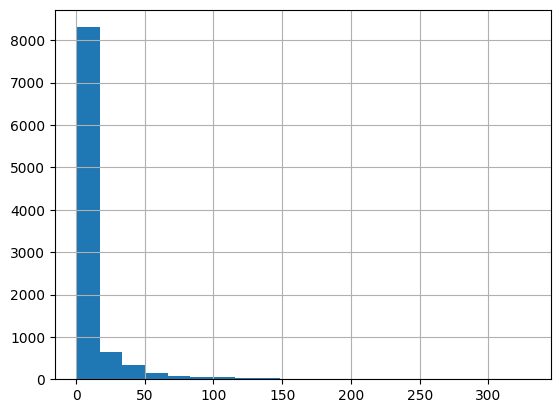

In [13]:
ratings.item_id.value_counts().hist(bins=20)

In [14]:
ratings.user_id.nunique()

610

<Axes: >

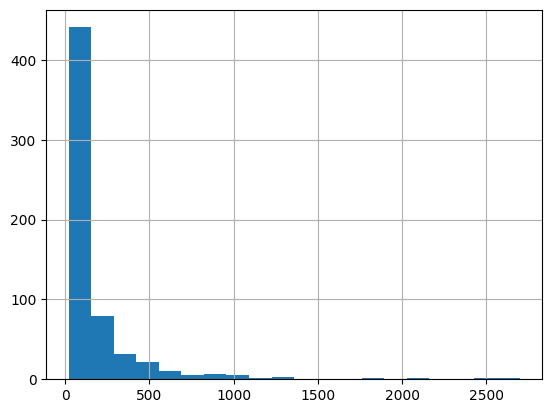

In [15]:
ratings.user_id.value_counts().hist(bins=20)

In [16]:
len(ratings)

100836

In [17]:
ratings = ratings.drop('timestamp', axis=1)

In [18]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
users_encoded = user_encoder.fit_transform(ratings.user_id)
items_encoded = item_encoder.fit_transform(ratings.item_id)
ratings.user_id = users_encoded
ratings.item_id = items_encoded

In [19]:
"""
notice how we could have used different strategies for the split.
1. By time
2. by user (to have not observed users yet) or item
3. what we did: have few items missing for each user
"""

train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42, stratify=ratings.user_id)

In [20]:
train_ratings.user_id.nunique() == ratings.user_id.nunique()

True

# Create ratings matrix

In [64]:
def create_ratings_matrix(ratings: pd.DataFrame):
    # preprocessing step required to be able to use unstack
    unique_ratings = ratings.groupby(["user_id", "item_id"]).mean()
    return unique_ratings.unstack().values

In [65]:
ratings_matrix = create_ratings_matrix(ratings)
for _, test_rating in tqdm(test_ratings.iterrows()):
    ratings_matrix[int(test_rating.user_id), int(test_rating.item_id)] = np.nan
# train_ratings_matrix = ratings_matrix[train_users, :]
# test_ratings_matrix =  ratings_matrix[test_users, :]
train_ratings_matrix = ratings_matrix

20168it [00:00, 37784.41it/s]


# Basic recommenders

In [144]:
from das_recommenders.basic import (
    ConstantRecommender,
    ItemMeanRecommender,
    UserMeanRecommender
)
from das_recommenders.collaborative_filtering.knn import (
    BasicKNNRecommender,
    NormalizedKNNRecommender,
    WeightedNormKNNRecommender,
)
from das_recommenders.collaborative_filtering.svd import SVDRecommender
from das_recommenders.collaborative_filtering.w2v import W2VRecommender
from das_recommenders.collaborative_filtering.ease import EASE
from das_recommenders.evaluate import evaluate

### Constant

In [31]:
recommender = ConstantRecommender()
recommender.fit(3)
evaluate(recommender, train_ratings_matrix, test_ratings)

100%|██████████| 610/610 [00:32<00:00, 18.66it/s]

RMSE: 1.1537894810582021, MAE: 0.9361612455374851, Recall at 50: 0.0032486275341349485, Precision at 5: 6.265172580926744e-05


### Constant: Dataset mean

In [547]:
print(train_ratings.rating.mean())
recommender = ConstantRecommender()
recommender.fit(train_ratings.rating.mean())
evaluate(recommender, train_ratings_matrix, test_ratings)

  4%|▎         | 22/610 [00:00<00:02, 218.85it/s]

3.501586750632221


100%|██████████| 610/610 [00:02<00:00, 251.46it/s]

RMSE: 1.037105586796965, MAE: 0.8242853475541899, Recall at 50: 0.0026528556650324904


### Item mean

In [549]:
recommender = ItemMeanRecommender()
recommender.fit(train_ratings_matrix)
evaluate(recommender, train_ratings_matrix, test_ratings)

100%|██████████| 610/610 [00:02<00:00, 233.42it/s]

RMSE: 0.9674179355035368, MAE: 0.7454629502501907, Recall at 50: 0.00020386357205668228


### User mean

In [550]:
recommender = UserMeanRecommender()
evaluate(recommender, train_ratings_matrix, test_ratings)

100%|██████████| 610/610 [00:02<00:00, 252.68it/s]

RMSE: 0.9373131028071089, MAE: 0.7320669707659181, Recall at 50: 0.0026528556650324904


# KNN recommenders

### Basic average

In [552]:
recommender = BasicKNNRecommender(similarity_type="correlation")
recommender.fit(train_ratings_matrix)
evaluate(recommender, train_ratings_matrix, test_ratings)

100%|██████████| 610/610 [01:38<00:00,  6.19it/s]

RMSE: 1.2297429379279445, MAE: 0.9247355008696178, Recall at 50: 0.02483321065430481


### Normalized average

In [553]:
recommender = NormalizedKNNRecommender(similarity_type="correlation")
recommender.fit(train_ratings_matrix)
evaluate(recommender, train_ratings_matrix, test_ratings, fraction=0.25)

100%|██████████| 152/152 [00:25<00:00,  5.95it/s]

RMSE: 1.1663678657726948, MAE: 0.9017855218205657, Recall at 50: 0.02720512299454543


In [554]:
recommender = NormalizedKNNRecommender(similarity_type="cosine")
recommender.fit(train_ratings_matrix)
evaluate(recommender, train_ratings_matrix, test_ratings, fraction=0.25)

100%|██████████| 152/152 [00:14<00:00, 10.36it/s]

RMSE: 0.9413028886291087, MAE: 0.7147418706389471, Recall at 50: 0.03301097627862756


### Weighted normalized average

In [556]:
recommender = WeightedNormKNNRecommender(similarity_type="correlation")
recommender.fit(train_ratings_matrix)
evaluate(recommender, train_ratings_matrix, test_ratings, fraction=0.25)

100%|██████████| 152/152 [00:24<00:00,  6.28it/s]

RMSE: 1.1650176875062734, MAE: 0.9011079563367076, Recall at 50: 0.027117403696299815


In [557]:
recommender = WeightedNormKNNRecommender(similarity_type="correlation", k=100)
recommender.fit(train_ratings_matrix)
evaluate(recommender, train_ratings_matrix, test_ratings, fraction=0.25)

100%|██████████| 152/152 [00:25<00:00,  5.85it/s]

RMSE: 0.9944082610563986, MAE: 0.760695567074061, Recall at 50: 0.006054384974055407


In [558]:
recommender = WeightedNormKNNRecommender(similarity_type="correlation", k=200)
recommender.fit(train_ratings_matrix)
evaluate(recommender, train_ratings_matrix, test_ratings, fraction=0.25)

100%|██████████| 152/152 [00:27<00:00,  5.58it/s]

RMSE: 0.89757663063764, MAE: 0.6857219502290782, Recall at 50: 0.0017641613502031076


In [559]:
recommender = WeightedNormKNNRecommender(similarity_type="cosine", k=200)
recommender.fit(train_ratings_matrix)
evaluate(recommender, train_ratings_matrix, test_ratings)

100%|██████████| 610/610 [01:18<00:00,  7.78it/s]

RMSE: 0.877438424532398, MAE: 0.6678703803216346, Recall at 50: 0.0011632420072102924


# SVD
Try it with various setting for k (number of factors, spoiler alert 10 is best).

Note: this could be improved with some automatized hyper-parameter optimization.

In [592]:
recommender = SVDRecommender(k=200)
recommender.fit(train_ratings_matrix)
evaluate(recommender, train_ratings_matrix, test_ratings)

performing SVD..
2 - 0.13706601156837386
0.13706601156837386 - 0.09859692572313226
0.09859692572313226 - 0.0741558301286086
0.0741558301286086 - 0.057064173183024
0.057064173183024 - 0.04460600452130993


  3%|▎         | 20/610 [00:00<00:03, 184.43it/s]

0.04460600452130993 - 0.035304413030310164


100%|██████████| 610/610 [00:02<00:00, 222.31it/s]

RMSE: 0.9362803849537101, MAE: 0.7294269612894572, Recall at 50: 0.08885386234813354


In [562]:
recommender = SVDRecommender(k=100)
recommender.fit(train_ratings_matrix)
evaluate(recommender, train_ratings_matrix, test_ratings)

performing SVD..
2 - 0.2719631826592722
0.2719631826592722 - 0.22764456531627814
0.22764456531627814 - 0.19400622484777186
0.19400622484777186 - 0.16740323284879638
0.16740323284879638 - 0.14593327844915044
0.14593327844915044 - 0.12833299699698572
0.12833299699698572 - 0.11367538693376013
0.11367538693376013 - 0.10132704349781693
0.10132704349781693 - 0.0907973384990324


  3%|▎         | 19/610 [00:00<00:03, 187.28it/s]

0.0907973384990324 - 0.08175503902716325


100%|██████████| 610/610 [00:02<00:00, 206.99it/s]

RMSE: 0.947699606235797, MAE: 0.7344015997011256, Recall at 50: 0.09877160753527728


In [563]:
recommender = SVDRecommender(k=50)
recommender.fit(train_ratings_matrix)
evaluate(recommender, train_ratings_matrix, test_ratings)

performing SVD..
2 - 0.4005921103794706
0.4005921103794706 - 0.3628144881516125
0.3628144881516125 - 0.3311365713656659
0.3311365713656659 - 0.3046420899891876
0.3046420899891876 - 0.2822417879907421
0.2822417879907421 - 0.2631216478793414
0.2631216478793414 - 0.24664960273890088
0.24664960273890088 - 0.23226396444221434
0.23226396444221434 - 0.21958434514240047
0.21958434514240047 - 0.20831889526185077
0.20831889526185077 - 0.19821813083795756


  3%|▎         | 20/610 [00:00<00:03, 195.45it/s]

0.19821813083795756 - 0.1891025871954492


100%|██████████| 610/610 [00:02<00:00, 211.53it/s]

RMSE: 0.9618984471373583, MAE: 0.7367694351558876, Recall at 50: 0.10588833438046202


In [564]:
recommender = SVDRecommender(k=30)
recommender.fit(train_ratings_matrix)
evaluate(recommender, train_ratings_matrix, test_ratings)

performing SVD..
2 - 0.4774894424094742
0.4774894424094742 - 0.4439815019783959
0.4439815019783959 - 0.4158349197371125
0.4158349197371125 - 0.39236476994786035
0.39236476994786035 - 0.3727431252617559
0.3727431252617559 - 0.35610409845486607
0.35610409845486607 - 0.34181421373015375
0.34181421373015375 - 0.32935013238427413
0.32935013238427413 - 0.3183135436471381


  3%|▎         | 19/610 [00:00<00:03, 183.78it/s]

0.3183135436471381 - 0.3084059122748499


100%|██████████| 610/610 [00:02<00:00, 220.24it/s]

RMSE: 0.9427776427626525, MAE: 0.7197256920749353, Recall at 50: 0.11234580718258651


In [565]:
recommender = SVDRecommender(k=15)
recommender.fit(train_ratings_matrix)
evaluate(recommender, train_ratings_matrix, test_ratings)

performing SVD..
2 - 0.5607903561583357
0.5607903561583357 - 0.5305236507403895
0.5305236507403895 - 0.508026306542596
0.508026306542596 - 0.48976397097852087
0.48976397097852087 - 0.4745547053980569
0.4745547053980569 - 0.4617118676482018
0.4617118676482018 - 0.45074366876499405


  7%|▋         | 42/610 [00:00<00:02, 198.59it/s]

0.45074366876499405 - 0.4412285582701423


100%|██████████| 610/610 [00:02<00:00, 209.09it/s]

RMSE: 0.9125609668511306, MAE: 0.6957822859930554, Recall at 50: 0.1263935999818712


In [566]:
recommender = SVDRecommender(k=10)
recommender.fit(train_ratings_matrix)
evaluate(recommender, train_ratings_matrix, test_ratings)

performing SVD..
2 - 0.5951083985690384
0.5951083985690384 - 0.5689485782583125
0.5689485782583125 - 0.5498154258597291
0.5498154258597291 - 0.5344632912715558
0.5344632912715558 - 0.5216714111977728
0.5216714111977728 - 0.5108120377880324


  3%|▎         | 20/610 [00:00<00:03, 193.22it/s]

0.5108120377880324 - 0.5015178806852197


100%|██████████| 610/610 [00:02<00:00, 218.02it/s]

RMSE: 0.8943819982654805, MAE: 0.6847153739993795, Recall at 50: 0.12570607148317262


# EASE

In [591]:
recommender = EASE()
recommender.fit(train_ratings_matrix)
evaluate(recommender, train_ratings_matrix, test_ratings)

100%|██████████| 610/610 [00:02<00:00, 208.32it/s]

RMSE: 0.9358479797267258, MAE: 0.7298167854104668, Recall at 50: 0.3159995721230011


# big dataset
SVD wasn't that accurate on small dataset, let's see if it improves on bigger snapshot of full data.

In [594]:
big_ratings = pd.read_csv("ml-latest-full/ratings.csv")

### Create reasonably sized subset
(bigger then ml-latest-small, but small than ml-latest-full)

In [595]:
sorted_items = big_ratings.movieId.value_counts().sort_values(ascending=False)

In [596]:
item_limited = big_ratings[big_ratings.movieId.isin(sorted_items.iloc[:20000].index)]

In [597]:
sorted_users = item_limited.userId.value_counts().sort_values(ascending=False)

In [598]:
user_item_limited = item_limited[item_limited.userId.isin(sorted_users.iloc[:3000].index)]
bratings = user_item_limited.drop('timestamp', axis=1)
bratings.columns = ['user_id', 'item_id', 'rating']

buser_encoder = LabelEncoder()
bitem_encoder = LabelEncoder()
busers_encoded = buser_encoder.fit_transform(bratings.user_id)
bitems_encoded = bitem_encoder.fit_transform(bratings.item_id)
bratings.user_id = busers_encoded
bratings.item_id = bitems_encoded
btrain_ratings, btest_ratings = train_test_split(bratings, test_size=0.2, random_state=42, stratify=bratings.user_id)

In [599]:
bratings_matrix = create_ratings_matrix(bratings)
for _, btest_rating in tqdm(btest_ratings.iterrows()):
    bratings_matrix[int(btest_rating.user_id), int(btest_rating.item_id)] = np.nan
btrain_ratings_matrix = bratings_matrix

884325it [01:05, 13469.50it/s]


In [602]:
recommender = SVDRecommender(k=10)
recommender.fit(btrain_ratings_matrix)
evaluate(recommender, btrain_ratings_matrix, btest_ratings)

performing SVD..
2 - 0.6413595627194869
0.6413595627194869 - 0.6097560782996019
0.6097560782996019 - 0.5938771077350034


  0%|          | 4/3000 [00:00<01:25, 35.24it/s]

0.5938771077350034 - 0.5839668950500824


100%|██████████| 3000/3000 [01:16<00:00, 39.47it/s]


RMSE: 0.7866115064776429, MAE: 0.5967425080200868, Recall at 50: 0.08468697293875944


SVD improved as expected, but we will not include it in benchmark as we would have to recompute
all the models on this snapshot and KNN methods are not implemented in a way to handle dataset
this big.

# w2v

In [24]:
train_ratings

,user_id,item_id,rating
21452,139,3142,3.0
22899,155,1543,1.0
58090,379,9649,4.0
79604,494,3759,3.5
100382,609,7028,3.0
...,...,...,...
49818,317,8912,3.0
66934,431,3915,1.5
74191,473,2993,2.0
80857,509,434,1.5


In [145]:
recommender = W2VRecommender(similarity_type="correlation")
recommender.fit(train_ratings, train_ratings_matrix)

In [146]:
evaluate(recommender, train_ratings_matrix, test_ratings)

  0%|          | 0/610 [00:00<?, ?it/s]

100%|██████████| 610/610 [00:05<00:00, 103.01it/s]


RMSE: 0.9909022937772373, MAE: 0.7577964192371703, Recall at 50: 0.05416001906101442, Precision at 5: 0.0018634584116679516


In [109]:
train_ratings_matrix.shape

(610, 9724)

In [138]:
recommender.w2v_model.wv.similarity(0, 6)

0.84711134